In [1]:
%matplotlib Inline
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models


In [2]:
#LOADING Pretrained VGG19 Model
vgg = models.vgg19(pretrained=True).features

#freezing all parameters but target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [3]:
#PASSING MODEL TO GPU
cuda_is_here = torch.cuda.is_available()
device = torch.device("cuda" if cuda_is_here else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [9]:
#LOADING IMAGES
import matplotlib.image as mpimg
def load_image(image_path, max_size = 500, shape=None ):
    #max size is to ensure image is not to large else my system crashes
    image = Image.open(image_path).convert('RGB')
    
    
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
        
    if shape is not None:
        size = shape
        
    #transforming the image
    transform = transforms.Compose([transforms.Resize(size), 
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5, 0.5, 0.5),
                                                      (0.5, 0.5, 0.5))])
    
    #discard the transparent, alpha channel and add batch dimension
    image = transform(image)[:3, :, :].unsqueeze(0)
    
    return image


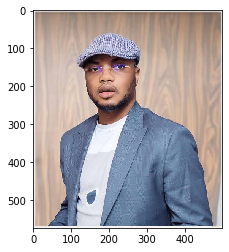

In [10]:
image = mpimg.imread(r'C:\Users\ogeel\OneDrive\Desktop\ML_ref images\CEO.jpg')
plt.imshow(image)

In [14]:
#Loading in content and style image
content = load_image(r'C:\Users\ogeel\OneDrive\Desktop\ML_ref images\CEO.jpg').to(device)

#Resize styleto match content 
style = load_image(r'C:\Users\ogeel\OneDrive\Desktop\ML_ref images\picasso1.jpg', shape = content.shape[-2:]). to(device)

In [15]:
#Convert Normalized Tensor image to numpy  image for display
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image*np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5))
    image = image.clip(0, 1)
    
    return image


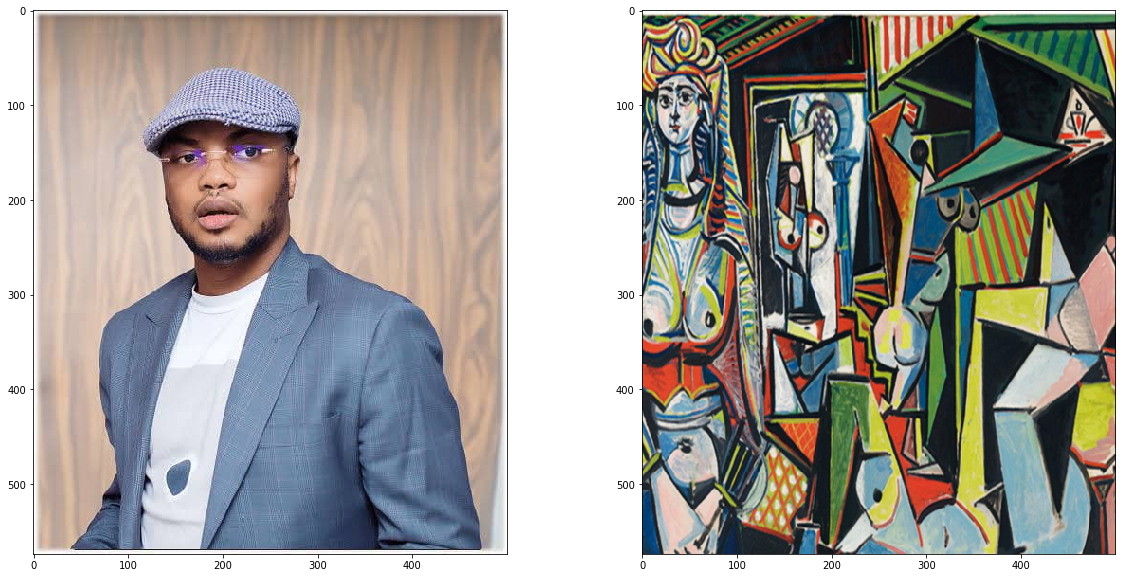

In [16]:
#displaying the image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,  10))
#content and style images
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))


In [21]:
def get_features(image, model, layers=None):
    
    if layers is None:
        layers = {'0' : 'conv1_1', ##Style Representation
                  '5' : 'conv2_1',
                  '10' : 'conv3_1',
                  '19' : 'conv4_1',
                  '21' : 'conv4_2',##Content Representation
                  '28' : 'conv5_1'
                  }
        
    features = {}
    x = image
    
    #using model.modules dictionary to access  each module within the model
    
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
        
        
    return features

In [22]:
#Computing gram matrix
def gram_matrix(tensor):
    b_s, d, h, w = tensor.size()
    
    #reshaping tensor by multiplying features for each channel
    tensor = tensor.view(d, h*w)
    
    #gram matrix calculation
    gram = torch.mm(tensor, tensor.t())
    
    return gram

In [23]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

#calculating gram matrix for each layer of our  styl  representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

target = content.clone().requires_grad_(True).to(device)

In [24]:
#LOSS AND WEIGHTS
style_weights = {'conv1_1' : 1.,
                 'conv2_1' : 0.8,
                 'conv3_1' : 0.2,
                 'conv4_1' : 0.3,
                 'conv5_1' : 0.6
                
                }

content_weight = 1 #alpha
style_weight = 1e6 #beta

Total loss: 4448570.0


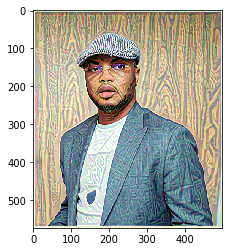

Total loss: 2069058.25


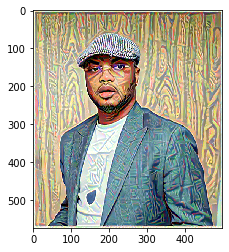

Total loss: 1381172.375


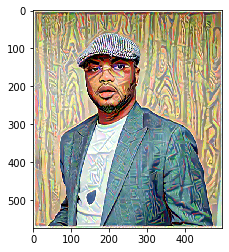

Total loss: 1036971.3125


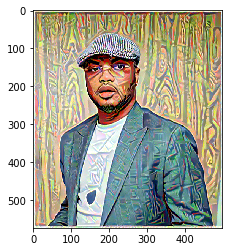

Total loss: 817486.5


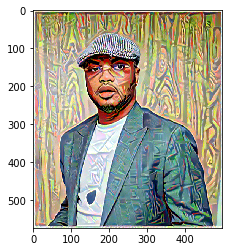

Total loss: 659528.875


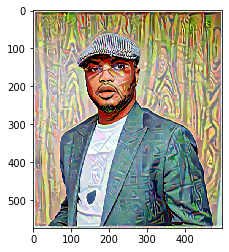

Total loss: 540498.9375


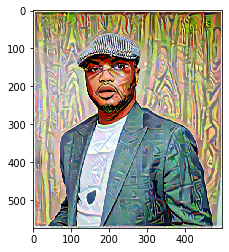

Total loss: 447221.5625


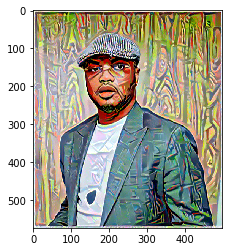

Total loss: 372074.5625


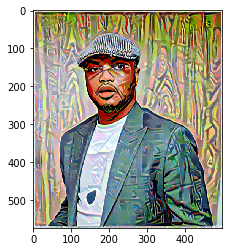

Total loss: 310456.78125


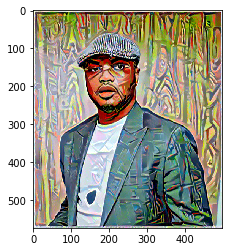

Total loss: 259797.75


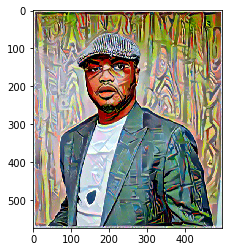

Total loss: 218047.078125


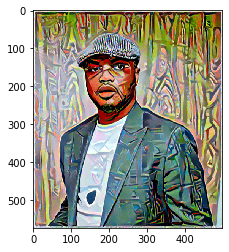

Total loss: 183701.265625


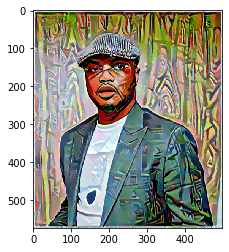

Total loss: 155509.421875


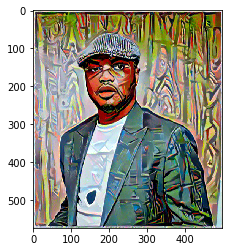

Total loss: 132642.3125


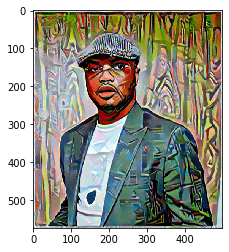

Total loss: 114764.40625


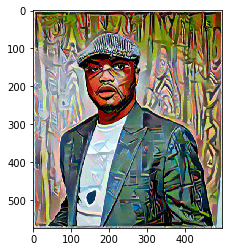

Total loss: 100552.0390625


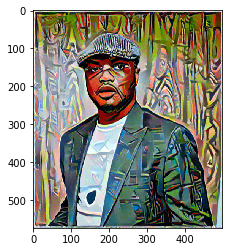

Total loss: 89643.4140625


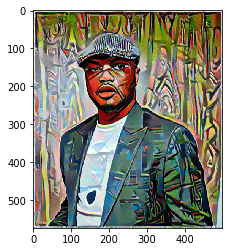

Total loss: 81465.7265625


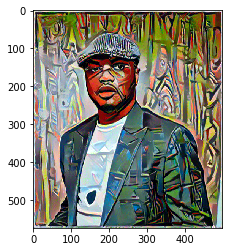

Total loss: 75594.9296875


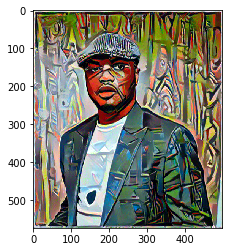

Total loss: 70708.4921875


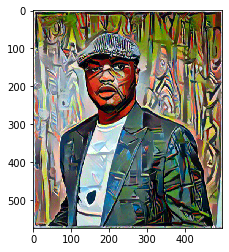

Total loss: 70003.0390625


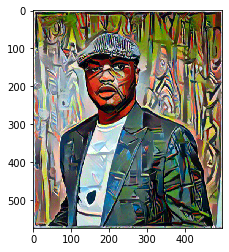

Total loss: 64336.66015625


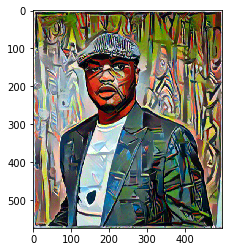

Total loss: 61730.3359375


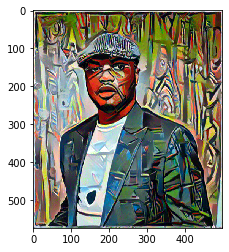

Total loss: 59788.1015625


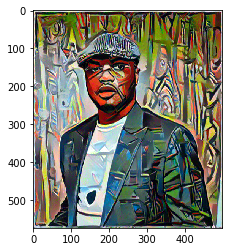

In [25]:
#iteration loop
#for displayinng the target image, itermittently
show_every  = 400

#iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 10000 

for ii in range(1, steps +1):
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    #initializing style loss to 0
    style_loss = 0
    #iterating through each layer and adding to the style loss
    for layer in style_weights:
        #getting target style representation for the layer
        target_feature = target_features[layer]
         
        #target gram matrix
        target_gram = gram_matrix(target_feature)
        
        b_s, d, h, w = target_feature.shape
       
        #getting style representation
        style_gram = style_grams[layer]
        
        #style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        
        #add to style loss
        style_loss += layer_style_loss / (d * h * w)
        
    #calculating total loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    #backpropagation for updating target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    #displaying intermediate images and print the loss
    if ii % show_every ==0:
        print('Total loss:', total_loss.item())
        plt.imshow(im_convert(target)) 
        plt.show()
    

In [ ]:
#DISPLAY CONTENT AND TARGET IMAGE
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))